REFS:

- https://developer.spotify.com/dashboard/login
- https://developer.spotify.com/documentation/web-api/reference/
- https://spotipy.readthedocs.io/en/latest/#

In this notebook I'll be using Spotify API to obtain more data about the lyrics we scrapped from the web in the last notebook. To have access to Spotify API is necessary to request you credentials at https://developer.spotify.com/dashboard/login.

I'll be using Spotipy which is a lightweight Python library for the [Spotify Web API](https://developer.spotify.com/documentation/web-api/).

In [1]:
import pandas as pd
import time

TodaysDate = time.strftime("%Y-%m-%d")


# Access to Spotify API 

In [2]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

try:
    import private # .py file with my credentials 
    # maybe redirect uri will be required for some of the commands 
    redirect_uri = private.redirect_uri

    # credentials
    username = private.username
    client_id=private.cid 
    client_secret=private.secret

except ModuleNotFoundError:
    import settings # have the credentials of another user
    redirect_uri = settings.redirect_uri

    # credentials
    username = settings.username
    client_id=settings.cid
    client_secret=settings.secret   
    
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Retrieving information about an artist

Spotipy supports a number of different ID types:

`Spotify URI` - The resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. Example: spotify:track:6rqhFgbbKwnb9MLmUQDhG6

`Spotify URL` - An HTML link that opens a track, album, app, playlist or other Spotify resource in a Spotify client. Example: http://open.spotify.com/track/6rqhFgbbKwnb9MLmUQDhG6

`Spotify ID` - A base-62 number that you can find at the end of the Spotify URI (see above) for an artist, track, album, etc. Example: 6rqhFgbbKwnb9MLmUQDhG6

In general, any Spotipy method that needs an _artist, album, track or playlist ID_ will accept ids in any of the above form.

**source: https://spotipy.readthedocs.io/en/latest/#ids-uris-and-urls**

In order to retrieve information about an artist we need to retrieve one of these IDs, for this we use the method `search`. In the function below we will use this and other methods from Spotipy to retrieve information about an artist.

The information retrieved by the following function is:



In [3]:
def retrieve_artist_info(artist):
    
    """ 
    
    Retrieve main information about an artist given artist's name which includes also name of bands.
    
    Input:
        artist : artist's name (string)
    
    Output:
        dictionary with main info about artist, including related artist. 
        
    """
    
    # find artist by name and extract uri
    
    artist_uri = sp.search(q='artist:' + artist, type='artist')['artists']['items'][0]['uri']
    
    # Extract info about artist
    
    artist_info = sp.artist(artist_uri)
    
    # Obtain list of related artists. Similarity is based on analysis of the Spotify community’s listening history.

    related = sp.artist_related_artists(artist_uri)
    
    related_artists = []

    for idx in range(len(related['artists'])):
        related_artists.append(related['artists'][idx]['name'])
    
    return {'id': artist_info['id'],
            'name' : artist_info['name'],
            'genres': ', '.join(artist_info['genres']),
            'artist_popularity' : artist_info['popularity'],
            'num_followers' : artist_info['followers']['total'],
            'related_artists': ', '.join(related_artists),
            'external_urls': artist_info['external_urls']['spotify'],
            'uri': artist_uri}
    

In [4]:
import pandas as pd

def build_dataframe_artists_info(list_artists):
    """ 
    Build a dataframe with info from a list of artists (names of artists)
    """
    
    all_info = []

    for name in list_artists:
        all_info.append(retrieve_artist_info(name))
        
    return pd.DataFrame(all_info)
    

In [5]:
df = build_dataframe_artists_info(['evanescence','within temptation'])
df.columns

Index(['id', 'name', 'genres', 'artist_popularity', 'num_followers',
       'related_artists', 'external_urls', 'uri'],
      dtype='object')

In [6]:
# selecting only the columns I'm interested in

df = df[['name', 'genres', 'artist_popularity', 'num_followers',
       'related_artists']]

df

,name,genres,artist_popularity,num_followers,related_artists
0,Evanescence,"alternative metal, post-grunge",76,2542183,"Amy Lee, We Are The Fallen, Within Temptation,..."
1,Within Temptation,"dutch metal, gothic metal, gothic symphonic me...",68,742444,"Leaves' Eyes, Delain, Epica, Tarja, Visions of..."


## Comparing Popularity and Number of Followers

Text(0.5, 1.0, 'Comparison of popularity - Evanescence x Within Temptation.\n')

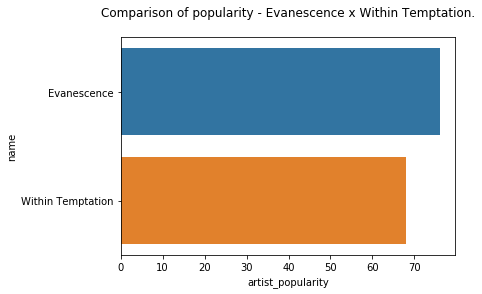

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.barplot(data=df, y='name',x='artist_popularity')
plt.title("Comparison of popularity - Evanescence x Within Temptation.\n")

Text(0.5, 1.0, 'Comparison of Number of Followers - Evanescence x Within Temptation.\n')

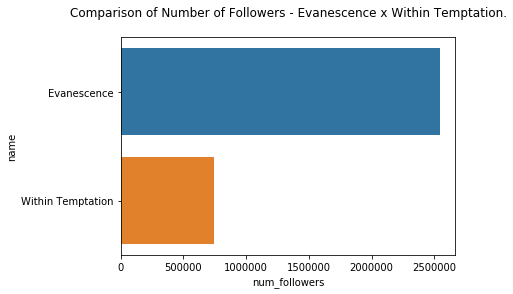

In [8]:
sns.barplot(data=df, y='name',x='num_followers')
plt.title("Comparison of Number of Followers - Evanescence x Within Temptation.\n")

## Genres and Related Artists

We will see more about Word Clouds in a next notebook where we will perform some NLP analysis (topic analysis and sentiment analysis). However, I'll make use of some word clouds to visualize the genres associated with each band as well as the artists related with them individually and also in common. 

In [9]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [10]:
# Generate word clouds with genres related to each band 

evanescence_genres_word_cloud = WordCloud(background_color="black",random_state=123,colormap='Reds').generate(df['genres'][df['name']=='Evanescence'][0])
within_genres_word_cloud = WordCloud(background_color="black",random_state=123,colormap='Blues').generate(df['genres'][df['name']=='Within Temptation'][1])


(-0.5, 399.5, 199.5, -0.5)

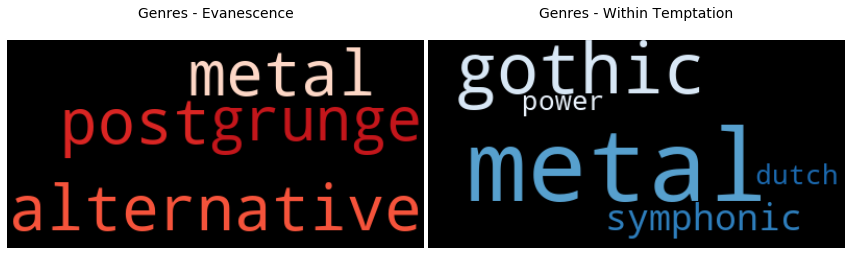

In [26]:
fig = plt.figure(figsize = (15,15))
plt.subplots_adjust(wspace=0.01)
plt.subplot(221)
plt.title("Genres - Evanescence\n", fontsize = 14 )
plt.imshow(evanescence_genres_word_cloud, interpolation="bilinear")
plt.axis('off')
plt.subplot(222)
plt.title("Genres - Within Temptation\n", fontsize = 14 )
plt.imshow(within_genres_word_cloud, interpolation="bilinear")
plt.axis('off')

## Which related artists Evanescence and Within Temptation have in common considering the listeners of Spotify?

In [27]:
common_artists = set(df['related_artists'][df['name']=='Evanescence'][0].split(',')).intersection(set(df['related_artists'][df['name']=='Within Temptation'][1].split(',')))
common_artists=','.join(common_artists)
common_artists

' Sirenia, Nightwish, Delain, Lacuna Coil, Epica, Tarja, We Are The Fallen'

In [28]:
evanescence_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Reds').generate(df['related_artists'][df['name']=='Evanescence'][0])
within_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Blues').generate(df['related_artists'][df['name']=='Within Temptation'][1])
common_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Purples').generate(common_artists)

(-0.5, 399.5, 199.5, -0.5)

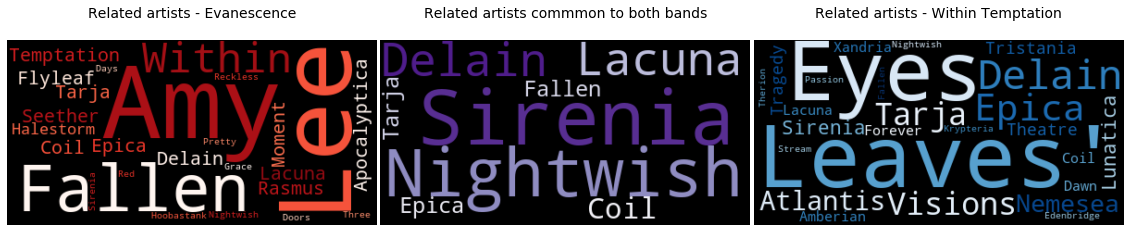

In [29]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(wspace=0.01)
plt.subplot(231)
plt.title("Related artists - Evanescence\n", fontsize = 14 )
plt.imshow(evanescence_artists_wc, interpolation="bilinear")
plt.axis('off')
plt.subplot(232)
plt.title("Related artists commmon to both bands\n", fontsize = 14 )
plt.imshow(common_artists_wc, interpolation="bilinear")
plt.axis('off')
plt.subplot(233)
plt.title("Related artists - Within Temptation\n", fontsize = 14 )
plt.imshow(within_artists_wc, interpolation="bilinear")
plt.axis('off')

So we can say that people that like `Evanescence` and `Within Temptation` also appreciate Sirenia, Nightwish, Delain, Lacuna Coil, Epica, Tarja, and We Are The Fallen. In a recommender system point of view we could recommend people to explore this bands ;-)

**Remark:** : Probably when you run the code the result will be different since the behaviour of the listeners in Spotify also changes with time.

# Artist top tracks

In [37]:
import pandas as pd

def top_tracks_by_country(artist_id, country = 'US'):
    """ 
    Get Spotify catalog information about an artist’s top 10 tracks by country. 
    """
    
    track_name = []
    track_id = []
    track_popularity = []

    top = sp.artist_top_tracks(artist_id, country)
    
    for idx in range(len(top['tracks'])):
        track_name.append(top['tracks'][idx]['name'])
        track_id.append(top['tracks'][idx]['id'])
        track_popularity.append(top['tracks'][idx]['popularity'])
        
    dict_top = {'track_id': track_id,
               'track_name': track_name,
               'track_popularity': track_popularity}
        
    return pd.DataFrame(dict_top)

In [38]:
evanescence_id = retrieve_artist_info('evanescence')['id']
df_evanescence_US = top_tracks_by_country(evanescence_id)
df_evanescence_US

,track_id,track_name,track_popularity
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54


In [39]:
df_evanescence_NL = top_tracks_by_country(evanescence_id, country='NL')
df_evanescence_NL

,track_id,track_name,track_popularity
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54


In [40]:
df_evanescence_US.equals(df_evanescence_NL)

True

Both countries have the same top 10 for Evanescence. 

In [41]:
df_top10_evanescence = df_evanescence_US.merge(df_evanescence_NL,on='track_name', suffixes=('_US', '_NL'))
df_top10_evanescence[['track_name', 'track_popularity_US','track_popularity_NL']]

,track_name,track_popularity_US,track_popularity_NL
0,Bring Me To Life,77,77
1,My Immortal,73,73
2,Going Under,68,68
3,Call Me When You're Sober,64,64
4,Everybody's Fool,62,62
5,Lithium,60,60
6,Hello,57,57
7,Tourniquet,56,56
8,Haunted,54,54
9,Taking Over Me,54,54


And what about withing Temptation?

In [42]:
within_temptation_id = retrieve_artist_info('within temptation')['id']

In [43]:
df_within_temptation_US = top_tracks_by_country(within_temptation_id)
df_within_temptation_NL = top_tracks_by_country(within_temptation_id, country = 'NL')
df_within_temptation_US.equals(df_within_temptation_NL)

False

It seems that the taste of americans and dutchs differ when we talk about Within Temptation. Let's see which one are the top 10 in both countries.

In [44]:
df_within_temptation_US

,track_id,track_name,track_popularity
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55
4,4GBbBy05LoSveNxjKxj26m,Supernova,54
5,5oX5jpeZsXBWEheqE0qqqD,Faster,52
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),52
7,7fm01f9fZNeQCYedC2xhcF,Paradise (What About Us?) [feat. Tarja],40
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51
9,17AtQU2FNV14jSGpPfhejn,Memories,50


In [45]:
df_within_temptation_NL

,track_id,track_name,track_popularity
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55
4,4GBbBy05LoSveNxjKxj26m,Supernova,54
5,28HX0PibeXSL6cfAsvwSgD,Faster,54
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),52
7,2Sp8T3BrAHQmWwl9jLexDF,Paradise (What About Us?) [feat. Tarja],52
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51
9,17AtQU2FNV14jSGpPfhejn,Memories,50


At the end both countries like the same songs. However, _Faster_ and _Paradise_ score better in popularity in The Netherlands.

In [46]:
df_top10_within = df_within_temptation_US.merge(df_within_temptation_NL,on='track_name', suffixes=('_US', '_NL'))
df_top10_within[['track_name', 'track_popularity_US','track_popularity_NL']]

,track_name,track_popularity_US,track_popularity_NL
0,The Reckoning,56,56
1,All I Need,56,56
2,Angels,55,55
3,Stand My Ground,55,55
4,Supernova,54,54
5,Faster,52,54
6,What Have You Done (feat. Keith Caputo),52,52
7,Paradise (What About Us?) [feat. Tarja],40,52
8,Endless War,51,51
9,Memories,50,50


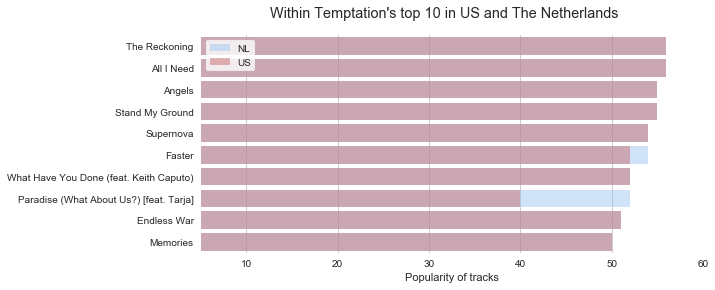

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(9, 4))

# Plot top 10 in NL
sns.set_color_codes("pastel")
sns.barplot(x="track_popularity_NL", y="track_name", data=df_top10_within,
            label="NL", color="b", alpha = 0.5)

# Plot top 10 in US
sns.set_color_codes("muted")
sns.barplot(x="track_popularity_US", y="track_name", data=df_top10_within,
            label="US", color="r", alpha = 0.5)

# Add a legend and informative axis label
f.suptitle("Within Temptation's top 10 in US and The Netherlands")
ax.legend(ncol=1, loc="upper left", frameon=True)
ax.set(xlim=(5, 60), ylabel="",
       xlabel="Popularity of tracks")
sns.despine(left=True, bottom=True)




**Track's Popularity:** Track's popularity has a value between 0 and 100, with 100 being the most popular. It is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

source: https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-top-tracks/

Curious to hear snippets of the top 10? Let's include `preview url` to above dataframes so you can have a taste ;-)

In [49]:
import sys
import pandas as pd
# import streamlit as st
pd.set_option('display.max_colwidth', 0)
from IPython.display import Image, HTML

def insert_preview_url(df):
    """ 
    Insert column with clickable link to snippet (30 seconds sample of a song) of songs.
    
    Input:
        df: Dataframe to have column with preview inserted. This dataframe contains a column with track_ids (df['track_id'])
    
    """
    
    list_preview_url = []

    for track_id in df['track_id']:
        list_preview_url.append(sp.track(track_id)['preview_url'])
        
    df['preview_url'] = list_preview_url
    
    def make_clickable(val):
        if val is None:
            return 'No preview available'
        else:
            return '<a target="_blank" href="{}">{}</a>'.format(val, val)

    return df.style.format({'preview_url': make_clickable})

In [50]:
# Updated dataframe with top 10 of Evanescence in The Netherlands

df = df_evanescence_NL
track_id_list = df_evanescence_NL['track_id']

df_evanescence_NL_preview = insert_preview_url(df)
df_evanescence_NL_preview

,track_id,track_name,track_popularity,preview_url
0,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,77,No preview available
1,4UzVcXufOhGUwF56HT7b8M,My Immortal,73,No preview available
2,3UygY7qW2cvG9Llkay6i1i,Going Under,68,No preview available
3,663Karu2rvKLdnY0eo1n3M,Call Me When You're Sober,64,No preview available
4,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,62,No preview available
5,5YaLFRpqpUzgLLDcukNn0H,Lithium,60,No preview available
6,0aYUqsvZG7bAslrUkd9Z0g,Hello,57,No preview available
7,46fyLy4W9HhAkcb67kLaAV,Tourniquet,56,No preview available
8,6Z77oDcn6iI1MHFCBPjl24,Haunted,54,No preview available
9,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,54,No preview available


In [51]:
# Updated dataframe with top 10 of Within Temptation in The Netherlands

df = df_within_temptation_NL
track_id_list = df_within_temptation_NL['track_id']

df_within_temptation_NL_preview = insert_preview_url(df)
df_within_temptation_NL_preview

,track_id,track_name,track_popularity,preview_url
0,6XnPopwCZ6odHVVqMsllL5,The Reckoning,56,No preview available
1,4BhqnM5lktowwfHqq2JYhg,All I Need,56,https://p.scdn.co/mp3-preview/613509e6725e4792adb26010c84bad6eae562b44?cid=63a77ff40e794a12ae216a18befde98c
2,3TEwbiC0GhIRStn3Eabtu7,Angels,55,https://p.scdn.co/mp3-preview/1dbf69a32db3b4d23f0311f2bfbd2afd40bfbfdf?cid=63a77ff40e794a12ae216a18befde98c
3,15z9QEJOBV6hDdWsdZwDKP,Stand My Ground,55,https://p.scdn.co/mp3-preview/86774c051d057643a6daaa1b1fdbdca0e2f7c2fc?cid=63a77ff40e794a12ae216a18befde98c
4,4GBbBy05LoSveNxjKxj26m,Supernova,54,No preview available
5,28HX0PibeXSL6cfAsvwSgD,Faster,54,https://p.scdn.co/mp3-preview/dbdeec5d31a3582fc06355d9c24d4fc49e7df7f7?cid=63a77ff40e794a12ae216a18befde98c
6,66wcihY2Y8ZSqux6EivMWa,What Have You Done (feat. Keith Caputo),52,https://p.scdn.co/mp3-preview/4969cdbad38904f03074b30f4a176c6c4408235c?cid=63a77ff40e794a12ae216a18befde98c
7,2Sp8T3BrAHQmWwl9jLexDF,Paradise (What About Us?) [feat. Tarja],52,https://p.scdn.co/mp3-preview/a359f9e3b8d97551260d6d0205ddf9d2edbe76c6?cid=63a77ff40e794a12ae216a18befde98c
8,5uDWqYSiWqWTXK9CbAKIA8,Endless War,51,No preview available
9,17AtQU2FNV14jSGpPfhejn,Memories,50,https://p.scdn.co/mp3-preview/5273e1ffb4bde07151663d8320a9a0235bb99a00?cid=63a77ff40e794a12ae216a18befde98c


Unfortunately, Spotify does not provide snippets for all songs. Bad surprise that no songs in the top 10 have no snippets. A shame...

# Retrieving album's information

We have already retrieved and analysed some information about the bands. Now we will use their `artist_id` to retrieve information about their albuns.

In [122]:
import pandas as pd
import time

TodaysDate = time.strftime("%Y-%m-%d")

def retrieve_albums_info(artist_id, file_name, limit = 50, max_nr_albums=2000):
    """ 
    Retrieve albums information of a given artist_id.
    
    Input:
        artist_id : The Spotify URI for the artist.
        file_name: name of the .csv that will have the information retrieved (without extension)
        
    Output:
        csv file with album information of a chosen artist
    
    
    """
    
    album_name = []
    album_id = []
    album_type = []
    artists = []
    release_date = []
    cover_album = []
    total_tracks = []
    available_markets = []
    total_available_markets = []
    album_uri = []

    for i in range(0,max_nr_albums,50):
        albums_per_artist = sp.artist_albums(artist_id, limit=limit, offset=i)
        for album in range(len(albums_per_artist['items'])):
            album_name.append(albums_per_artist['items'][album]['name'])
            album_id.append(albums_per_artist['items'][album]['id'])
            album_type.append(albums_per_artist['items'][album]['album_type'])
            artists.append(albums_per_artist['items'][album]['artists'][0]['name'])
            release_date.append(albums_per_artist['items'][album]['release_date'])
            cover_album.append(albums_per_artist['items'][album]['images'][0]['url'])
            total_tracks.append(albums_per_artist['items'][album]['total_tracks'])
            available_markets.append(','.join(albums_per_artist['items'][album]['available_markets']))
            total_available_markets.append(len(albums_per_artist['items'][album]['available_markets']))
        
            album_uri.append(albums_per_artist['items'][album]['uri'])

    dict_albums = {'album_name':album_name,
                   'album_id': album_id,
                   'album_type' : album_type,
                   'artists': artists,
                   'release_date' : release_date,
                   'cover_album':cover_album,
                   'total_tracks':total_tracks,
                   'available_markets': available_markets,
                   'total_available_markets':total_available_markets,
                  'album_uri': album_uri}

    # creating dataframe

    df = pd.DataFrame(dict_albums)
    
    # Ordering by date - most recent first
    
    df.sort_values(by='release_date', inplace = True)

    # dropping duplicates based on album_name and release_date

    df.drop_duplicates(subset=['album_name','release_date'], keep = 'first', inplace = True)
    
    # reset index
    
    df.reset_index(drop=True,inplace = True)
    
    # Create year column
    
    df['release_date'] = pd.to_datetime(df['release_date'],  format='%Y-%m-%d')
    
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # Ordering
    
    df = df[['album_id', 'album_name', 'album_type', 'artists', 'release_year','release_date', 'cover_album',
            'total_tracks','available_markets','total_available_markets', 'album_uri']]

    # saving result in csv

    df.to_csv("./data/"+file_name+"_"+TodaysDate+".csv", index = False)
    
    return df


## Albums information - Evanescence

In [123]:
df_albums_evanescence = retrieve_albums_info(artist_id=retrieve_artist_info('evanescence')['id'], 
                                             file_name='info_Evanescence_albums', limit = 50, max_nr_albums=2000)
df_albums_evanescence.head()

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
2,5oi50Gv8yvqAqPbWDdZhYA,Elektra: The Album,compilation,Various Artists,2005,2005-01-01,https://i.scdn.co/image/9a8a5765f320549f0276ff5df8f9a11f1f4c9719,15,US,1,spotify:album:5oi50Gv8yvqAqPbWDdZhYA
3,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
4,7soKb31c9JTxBllcJ0J2KT,Now! 12,compilation,Various Artists,2007,2007-01-01,https://i.scdn.co/image/91dfccfbd04e0fa65584890f7a28b4d425b391cf,18,CA,1,spotify:album:7soKb31c9JTxBllcJ0J2KT


In [124]:
df_albums_evanescence.shape

(77, 11)

Using some [Pandas dataframe plots](https://pandas.pydata.org/pandas-docs/version/0.23.1/generated/pandas.DataFrame.plot.html) to visualize some information concerning albums of both bands.

Text(0.5, 1.0, "Number of album's type - Evanescence.\n")

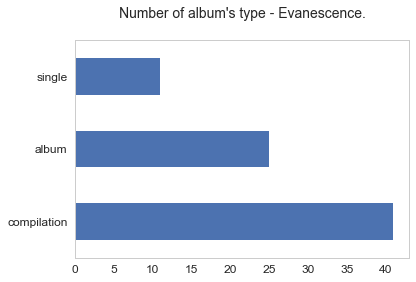

In [125]:
ax = df_albums_evanescence['album_type'].value_counts().plot.barh(grid = False, fontsize = 12)
ax.set_title("Number of album's type - Evanescence.\n", fontsize = 14)

Text(0.5, 1, "Number of 'artists' in albums - Evanescence.\n")

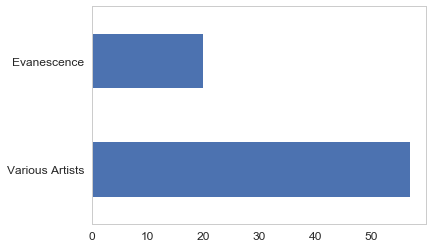

In [126]:
df_albums_evanescence['artists'].value_counts().plot.barh(grid = False, fontsize = 12)
ax.set_title("Number of 'artists' in albums - Evanescence.\n", fontsize = 14)

Text(0.5, 1.0, "Number of artists per album's type - Evanescence.\n")

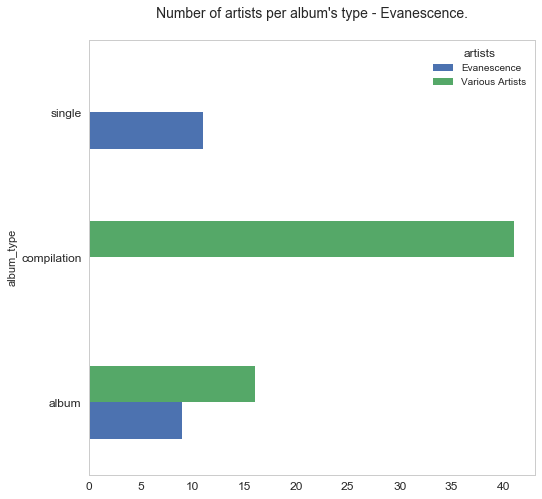

In [127]:
ax = df_albums_evanescence.groupby('artists').album_type.value_counts().unstack(0).plot.barh(figsize=(8,8), 
                                                                                        grid = False, fontsize = 12)
ax.set_title("Number of artists per album's type - Evanescence.\n", fontsize = 14)

## Albums information - Within Temptation

In [128]:
df_albums_within_temptation = retrieve_albums_info(artist_id=retrieve_artist_info('Within Temptation')['id'], 
                                             file_name='info_within_temptation_albums', limit = 50, max_nr_albums=2000)
df_albums_within_temptation.head()

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,4bHxlso02RaAgI7VRUpbrz,Enter,album,Within Temptation,1997,1997-04-06,https://i.scdn.co/image/9352f348651e97012aa19bc1ec18bff30b5b9bb9,8,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:4bHxlso02RaAgI7VRUpbrz
1,63rlrEjFSRaN6ZP41vzJ7t,The Dance,single,Within Temptation,1998,1998-07-21,https://i.scdn.co/image/1d733aaf4aaffb9787b3061d38b18ba86dfa063e,5,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:63rlrEjFSRaN6ZP41vzJ7t
2,2eUdhPZOgcYV4EU2lZC8xQ,Mother Earth,album,Within Temptation,2000,2000-12-24,https://i.scdn.co/image/71dd03b780d05712f6ecf482a188e000a1677030,14,"BE,BR,LU,NL",4,spotify:album:2eUdhPZOgcYV4EU2lZC8xQ
3,01J8f25FtFdLr9RkEjLdHV,Stand My Ground,single,Within Temptation,2001,2001-01-01,https://i.scdn.co/image/ab67616d0000b273fcef90f88820ab7271ac3e71,3,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HN,HU,IE,IL,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,NI,NL,NO,NZ,OM,PA,PE,PL,PS,PT,PY,QA,RO,SA,SE,SK,SV,TN,TR,UY,ZA",68,spotify:album:01J8f25FtFdLr9RkEjLdHV
4,5xgEqUqTQ19PPt5bElrS7V,Mother Earth,album,Within Temptation,2003,2003-02-17,https://i.scdn.co/image/ab67616d0000b27395d715c7953b9852c4870dc6,14,"AD,AE,AR,AT,AU,BG,BH,BO,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LV,MA,MC,MT,MX,MY,NI,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",75,spotify:album:5xgEqUqTQ19PPt5bElrS7V


In [129]:
df_albums_within_temptation.shape

(121, 11)

Text(0.5, 1, "Number of album's type - Within Temptation.\n")

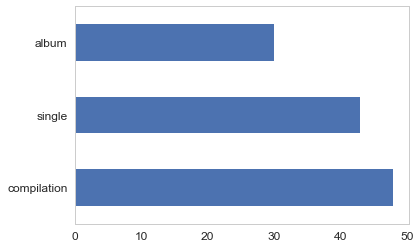

In [130]:
df_albums_within_temptation['album_type'].value_counts().plot.barh(grid = False, fontsize = 12)
ax.set_title("Number of album's type - Within Temptation.\n", fontsize = 14)

Text(0.5, 1, "Number of 'artists' in albums - Within Temptation.\n")

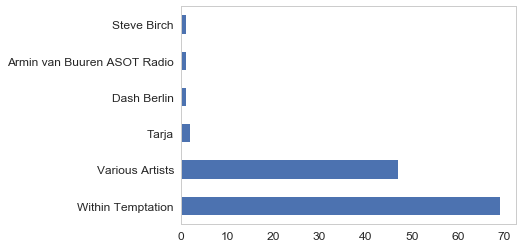

In [131]:
df_albums_within_temptation['artists'].value_counts().plot.barh(grid = False, fontsize = 12)
ax.set_title("Number of 'artists' in albums - Within Temptation.\n", fontsize = 14)

Text(0.5, 1.0, "Number of artists per album's type - Within Temptation.\n")

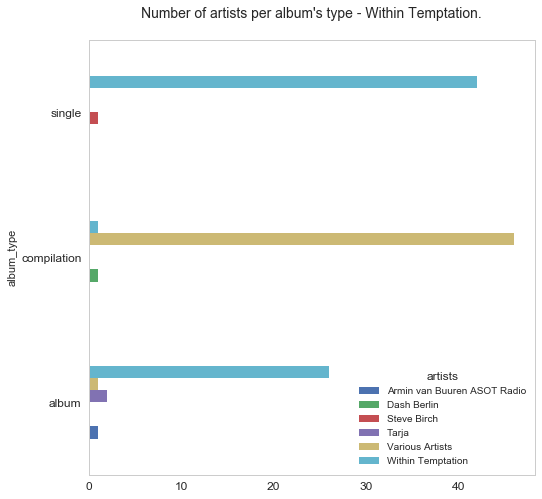

In [132]:
ax = df_albums_within_temptation.groupby('artists').album_type.value_counts().unstack(0).plot.barh(figsize=(8,8), 
                                                                                        grid = False, fontsize = 12)
ax.set_title("Number of artists per album's type - Within Temptation.\n", fontsize = 14)

I'll filter the information retrieved about albums such that I have albums only with the band considered. 

From the plots above we can see that for `Evanescence` compilation is only when there are Various Artists. However, the same doesn't hold for `Within Temptation`. There are compilations with only `Within Temptation`. So we will check it before applying our filtering to be sure.


In [133]:
df_albums_within_temptation[(df_albums_within_temptation["album_type"]=='compilation') 
                            & (df_albums_within_temptation["artists"]=='Within Temptation')]

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
84,3eOkgpO5Nj9O8bkumoOoeP,Hydra,compilation,Within Temptation,2014,2014-04-02,https://i.scdn.co/image/ab67616d0000b273f863a1d6c7d3d2ce913ddfa7,10,US,1,spotify:album:3eOkgpO5Nj9O8bkumoOoeP


In [134]:
df_albums_within_temptation[df_albums_within_temptation["album_name"]=='Hydra']

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
78,1n8Dw55DnfiRRsbf6xWdoF,Hydra,album,Within Temptation,2014,2014-01-22,https://i.scdn.co/image/ab67616d0000b273ecd5404a8a3bc42cc794eec7,10,JP,1,spotify:album:1n8Dw55DnfiRRsbf6xWdoF
79,2mgmC1O47IwqsPth7BG3P2,Hydra,album,Within Temptation,2014,2014-01-31,https://i.scdn.co/image/ab67616d0000b273cf31e1bca9c4dab73d20fb0f,10,US,1,spotify:album:2mgmC1O47IwqsPth7BG3P2
80,1sb2uwndOTnKrQGjQleKYZ,Hydra,album,Within Temptation,2014,2014-02-04,https://i.scdn.co/image/735ace0df093981ee44eef7e02d13435484a1cb7,10,"AR,BO,CL,CO,EC,PE,PY,UY",8,spotify:album:1sb2uwndOTnKrQGjQleKYZ
84,3eOkgpO5Nj9O8bkumoOoeP,Hydra,compilation,Within Temptation,2014,2014-04-02,https://i.scdn.co/image/ab67616d0000b273f863a1d6c7d3d2ce913ddfa7,10,US,1,spotify:album:3eOkgpO5Nj9O8bkumoOoeP


The album `Hydra` was classified as _compilation_ in the US. All 4 entries have 10 tracks.

## Keep only albums of the artist of interest

Therefore, our filtering will consist for both bands in keeping `album_type`: album and `artists`the band self.

The reason I'm not usually including compilations is because they usually are an ensemble of tracks of differnt artists. Singles are also not included because usually, they are included later in an album.

### Evanescence

In [135]:
df_albums_evanescence[df_albums_evanescence['artists']=='Evanescence'].head(10)

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
3,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
8,6HuLNUKcAkcIUSKZxRU9sO,Together Again,single,Evanescence,2010,2010-01-01,https://i.scdn.co/image/4b7da0b6ca9311f9e02cdd2b93d3928787d8752c,1,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:6HuLNUKcAkcIUSKZxRU9sO
9,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
10,0CHgu3JbE3Y0XQSejmQqLU,Evanescence (Deluxe Version),album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,16,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0CHgu3JbE3Y0XQSejmQqLU
16,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
17,0P2m1IsAPVcRGmnBUTW8G7,Bring Me to Life (Synthesis),single,Evanescence,2017,2017-08-18,https://i.scdn.co/image/ab67616d0000b273fab9215ecb7f554852aa0143,1,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SG,SK,TH,TN,TR,TW,VN,ZA",57,spotify:album:0P2m1IsAPVcRGmnBUTW8G7
18,75txZS6Wt4fL3rFrrSJtzC,Bring Me To Life (Synthesis),single,Evanescence,2017,2017-08-18,https://i.scdn.co/image/ab67616d0000b2739157db1440aaf30f3d8fa78d,1,"AR,BO,BR,CA,CL,CO,CR,DO,EC,GT,HN,MX,NI,PA,PE,PY,SV,US,UY",19,spotify:album:75txZS6Wt4fL3rFrrSJtzC
19,5jZYa2Za6usEVssTFuIFY0,Bring Me To Life (Synthesis),single,Evanescence,2017,2017-09-01,https://i.scdn.co/image/cf6c12b472831b8b2397be6a0008cc6d139b2205,1,JP,1,spotify:album:5jZYa2Za6usEVssTFuIFY0


There is a new single from `Evanescence` but it is not yet in an album. 

I can keep the information of the last released single of Evanescence to be included after filtering.

In [136]:
single_ID = df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')].iloc[0]['album_id']
single_ID

'053OECifPxrpiOKbiaP5Nm'

In [137]:
df_albums_evanescence_filtered = df_albums_evanescence.copy()

# only albums of type 'album' and from artist 'Evanescence'
df_albums_evanescence_filtered = df_albums_evanescence_filtered[(df_albums_evanescence_filtered['album_type']=='album')
                                                                &(df_albums_evanescence_filtered['artists']=='Evanescence')]

# reset index
df_albums_evanescence_filtered.reset_index(inplace=True, drop = True)

df_albums_evanescence_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
2,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
3,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
4,0CHgu3JbE3Y0XQSejmQqLU,Evanescence (Deluxe Version),album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,16,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0CHgu3JbE3Y0XQSejmQqLU
5,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
6,78S8Z3EOl7hbzePSH4GQyF,Synthesis,album,Evanescence,2017,2017-11-08,https://i.scdn.co/image/ef1c21ca628a5f82986728a14c9b54949c189060,16,JP,1,spotify:album:78S8Z3EOl7hbzePSH4GQyF
7,3kGK5hw7ldSXMOg8tTwHJK,Synthesis,album,Evanescence,2017,2017-11-10,https://i.scdn.co/image/ab67616d0000b273df572320cd13f0ad58f8f42b,16,"AD,AT,BE,BG,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HU,IE,IL,IS,IT,LI,LT,LU,LV,MA,MC,MT,NL,NO,PL,PT,RO,SE,SK,TN,TR,ZA",39,spotify:album:3kGK5hw7ldSXMOg8tTwHJK
8,12NBjimNnuWAP0OXIlwyrZ,Synthesis Live,album,Evanescence,2018,2018-12-14,https://i.scdn.co/image/ab67616d0000b273d7d7b2503d4ac3964cc87a5b,16,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:12NBjimNnuWAP0OXIlwyrZ


In [138]:
df_albums_evanescence_filtered.shape

(9, 11)

Initially, we retrieved 77 albums. After, filtering we kept 9 albums which are not single or compilation. Notice that two of them have repeated entries. Album `Evanescence` have two versions where the Deluxe version has more tracks. On the other side, album `Synthesis` has also two versions (studio and Live). However, they have the same number of tracks. There is also another entry for `Synthesis` for the studio version with a different release date. Apparently, in Japan this album was released 2 days after the other countries. Because album `Synthesis` seems to differ only on the release date we will apply another filtering to eliminate this case. 

In [139]:
df_albums_evanescence_filtered.drop_duplicates(subset=['album_name','release_year','total_tracks'], keep='first', inplace = True)

In [140]:
df_albums_evanescence_filtered.reset_index(inplace=True, drop=True)
df_albums_evanescence_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
2,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
3,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
4,0CHgu3JbE3Y0XQSejmQqLU,Evanescence (Deluxe Version),album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,16,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0CHgu3JbE3Y0XQSejmQqLU
5,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
6,78S8Z3EOl7hbzePSH4GQyF,Synthesis,album,Evanescence,2017,2017-11-08,https://i.scdn.co/image/ef1c21ca628a5f82986728a14c9b54949c189060,16,JP,1,spotify:album:78S8Z3EOl7hbzePSH4GQyF
7,12NBjimNnuWAP0OXIlwyrZ,Synthesis Live,album,Evanescence,2018,2018-12-14,https://i.scdn.co/image/ab67616d0000b273d7d7b2503d4ac3964cc87a5b,16,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:12NBjimNnuWAP0OXIlwyrZ


At this point we have 8 albums and we are still keeping the two versions of `Evanescence` and `Synthesis`. I'll add the new single resulting in a dataframe with 8 albuns and a single.

Any repeated tracks will be eliminated later. Now we use the `album_id` of these 8 albums and the last single, `The Chain` to retrieve inormation about their tracks.

Just confirmed in the [official site of Evanescence](http://www.evanescence.com/music/) that the albums retrieved are the ones listed in the dataframe above (not Live of Deluxe version).

In [141]:
new_single = df_albums_evanescence[df_albums_evanescence['album_id']==single_ID]

In [142]:
df_albums_evanescence_filtered = pd.concat([df_albums_evanescence_filtered,new_single])
# organize by album's release date
df_albums_evanescence_filtered = df_albums_evanescence_filtered.sort_values(by='release_year')
# reset index
df_albums_evanescence_filtered.reset_index(inplace=True, drop = True)

df_albums_evanescence_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,02w1xMzzdF2OJxTeh1basm,Fallen,album,Evanescence,2003,2003-01-01,https://i.scdn.co/image/25d08410eb1e3cadc3834f6de7dfed6bc8e277be,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:02w1xMzzdF2OJxTeh1basm
1,5SpQ4sf9sXFWHgUKYCZSDF,Anywhere But Home (Live),album,Evanescence,2004,2004-01-01,https://i.scdn.co/image/baa1db3acd78e252289618513899945055075ea5,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:5SpQ4sf9sXFWHgUKYCZSDF
2,3lFQ9ihSNR5YD0yi0yTzdC,The Open Door,album,Evanescence,2006,2006-01-01,https://i.scdn.co/image/bd3cdbd88ea146ba5bcc31738ae34471a7bc22a9,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC
3,3U85Q4GtR0I3VwgDOKHttO,Evanescence,album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:3U85Q4GtR0I3VwgDOKHttO
4,0CHgu3JbE3Y0XQSejmQqLU,Evanescence (Deluxe Version),album,Evanescence,2011,2011-01-01,https://i.scdn.co/image/660b8cc102ad45e105f8c591c7175bf96534ad01,16,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0CHgu3JbE3Y0XQSejmQqLU
5,55VNOaV0zcQqGSrjOBHKVG,Lost Whispers,album,Evanescence,2016,2016-01-01,https://i.scdn.co/image/5cc5773196912b58bb4d0ff434ad879f09898818,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:55VNOaV0zcQqGSrjOBHKVG
6,78S8Z3EOl7hbzePSH4GQyF,Synthesis,album,Evanescence,2017,2017-11-08,https://i.scdn.co/image/ef1c21ca628a5f82986728a14c9b54949c189060,16,JP,1,spotify:album:78S8Z3EOl7hbzePSH4GQyF
7,12NBjimNnuWAP0OXIlwyrZ,Synthesis Live,album,Evanescence,2018,2018-12-14,https://i.scdn.co/image/ab67616d0000b273d7d7b2503d4ac3964cc87a5b,16,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:12NBjimNnuWAP0OXIlwyrZ
8,053OECifPxrpiOKbiaP5Nm,The Chain,single,Evanescence,2019,2019-11-22,https://i.scdn.co/image/0123256dd623e1e33af9f783b6b6aca01c491e0b,1,"AD,AE,AT,AU,BE,BG,BH,CH,CY,CZ,DE,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HK,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MY,NL,NO,NZ,OM,PH,PL,PT,QA,RO,SA,SE,SG,SK,TH,TN,TR,TW,VN,ZA",58,spotify:album:053OECifPxrpiOKbiaP5Nm


In [143]:
df_albums_evanescence_filtered.shape

(9, 11)

### Within Temptation

In [144]:
df_albums_within_temptation[df_albums_within_temptation['artists']=='Within Temptation'].head(10)

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,4bHxlso02RaAgI7VRUpbrz,Enter,album,Within Temptation,1997,1997-04-06,https://i.scdn.co/image/9352f348651e97012aa19bc1ec18bff30b5b9bb9,8,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:4bHxlso02RaAgI7VRUpbrz
1,63rlrEjFSRaN6ZP41vzJ7t,The Dance,single,Within Temptation,1998,1998-07-21,https://i.scdn.co/image/1d733aaf4aaffb9787b3061d38b18ba86dfa063e,5,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:63rlrEjFSRaN6ZP41vzJ7t
2,2eUdhPZOgcYV4EU2lZC8xQ,Mother Earth,album,Within Temptation,2000,2000-12-24,https://i.scdn.co/image/71dd03b780d05712f6ecf482a188e000a1677030,14,"BE,BR,LU,NL",4,spotify:album:2eUdhPZOgcYV4EU2lZC8xQ
3,01J8f25FtFdLr9RkEjLdHV,Stand My Ground,single,Within Temptation,2001,2001-01-01,https://i.scdn.co/image/ab67616d0000b273fcef90f88820ab7271ac3e71,3,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HN,HU,IE,IL,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,NI,NL,NO,NZ,OM,PA,PE,PL,PS,PT,PY,QA,RO,SA,SE,SK,SV,TN,TR,UY,ZA",68,spotify:album:01J8f25FtFdLr9RkEjLdHV
4,5xgEqUqTQ19PPt5bElrS7V,Mother Earth,album,Within Temptation,2003,2003-02-17,https://i.scdn.co/image/ab67616d0000b27395d715c7953b9852c4870dc6,14,"AD,AE,AR,AT,AU,BG,BH,BO,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LV,MA,MC,MT,MX,MY,NI,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",75,spotify:album:5xgEqUqTQ19PPt5bElrS7V
5,4j5gtY29b8exlWOFL7WhGe,Mother Earth,single,Within Temptation,2003,2003-10-03,https://i.scdn.co/image/ab67616d0000b273649a0772b3d615b048c54e81,5,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",77,spotify:album:4j5gtY29b8exlWOFL7WhGe
7,7BO8ztdVgp7rPuQhED9xVw,Stand My Ground,single,Within Temptation,2004,2004-10-25,https://i.scdn.co/image/ab67616d0000b273853760ee5786e221aeeb51fa,4,"AE,AR,AU,BH,BO,BR,CL,CO,CR,DO,EC,EG,GT,HN,JO,KW,LB,MX,NI,NZ,OM,PA,PE,PS,PY,QA,SA,SV,UY",29,spotify:album:7BO8ztdVgp7rPuQhED9xVw
8,7Mqb9JDLwwr4kLuNXFnuJZ,The Silent Force,album,Within Temptation,2004,2004-11-15,https://i.scdn.co/image/ab67616d0000b27385fc8567babaf945bda677c3,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:7Mqb9JDLwwr4kLuNXFnuJZ
9,6BMdKIrwWJ0kg1U0kz4EqZ,Memories,single,Within Temptation,2005,2005-01-31,https://i.scdn.co/image/ab67616d0000b27347611e012bb98c01bdc6ea5b,4,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",77,spotify:album:6BMdKIrwWJ0kg1U0kz4EqZ
12,4GTAWyejCsSEQbXADPAiqA,What Have You Done,single,Within Temptation,2007,2007-01-03,https://i.scdn.co/image/ab67616d0000b2731a4c982cfd97140a5370759a,2,"AD,AE,AR,AT,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HN,HU,IE,IL,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,NI,NL,NO,OM,PA,PE,PL,PS,PT,PY,QA,RO,SA,SE,SK,SV,TN,TR,UY,ZA",67,spotify:album:4GTAWyejCsSEQbXADPAiqA


All the last singles from `Within Temptation` are already in an album.

In [145]:
df_albums_within_temptation_filtered = df_albums_within_temptation.copy()

# only albums of type 'album' and from artist 'within_temptation'
df_albums_within_temptation_filtered = df_albums_within_temptation_filtered[((df_albums_within_temptation_filtered['album_type']=='album')
                                                                &(df_albums_within_temptation_filtered['artists']=='Within Temptation'))]

# reset index
df_albums_within_temptation_filtered.reset_index(inplace=True, drop = True)

df_albums_within_temptation_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,4bHxlso02RaAgI7VRUpbrz,Enter,album,Within Temptation,1997,1997-04-06,https://i.scdn.co/image/9352f348651e97012aa19bc1ec18bff30b5b9bb9,8,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:4bHxlso02RaAgI7VRUpbrz
1,2eUdhPZOgcYV4EU2lZC8xQ,Mother Earth,album,Within Temptation,2000,2000-12-24,https://i.scdn.co/image/71dd03b780d05712f6ecf482a188e000a1677030,14,"BE,BR,LU,NL",4,spotify:album:2eUdhPZOgcYV4EU2lZC8xQ
2,5xgEqUqTQ19PPt5bElrS7V,Mother Earth,album,Within Temptation,2003,2003-02-17,https://i.scdn.co/image/ab67616d0000b27395d715c7953b9852c4870dc6,14,"AD,AE,AR,AT,AU,BG,BH,BO,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LV,MA,MC,MT,MX,MY,NI,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",75,spotify:album:5xgEqUqTQ19PPt5bElrS7V
3,7Mqb9JDLwwr4kLuNXFnuJZ,The Silent Force,album,Within Temptation,2004,2004-11-15,https://i.scdn.co/image/ab67616d0000b27385fc8567babaf945bda677c3,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:7Mqb9JDLwwr4kLuNXFnuJZ
4,3WweYGpwPZWT6WFMsV0iad,The Heart Of Everything,album,Within Temptation,2007,2007-03-09,https://i.scdn.co/image/ab67616d0000b2736690b84f646fe61e6bfea537,11,"AR,AT,BO,BR,CH,CL,CO,CR,DK,DO,EC,ES,GB,GT,HN,IS,JP,LI,MX,NI,PA,PE,PY,SV,UY",25,spotify:album:3WweYGpwPZWT6WFMsV0iad
5,0X5oJQ6o4rTeAtunxjSF1x,The Heart of Everything,album,Within Temptation,2007,2007-03-09,https://i.scdn.co/image/ab67616d0000b2739da438eca0065b845ff1e5cc,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0X5oJQ6o4rTeAtunxjSF1x
6,32ROP0fhFZxRS91q7C2mQU,The Heart Of Everything,album,Within Temptation,2007,2007-11-09,https://i.scdn.co/image/ab67616d0000b2731a1286f276e7390de7c30cbd,16,"AD,AE,BE,BG,BH,CY,CZ,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HU,IE,IL,IS,IT,JO,KW,LB,LT,LU,LV,MA,MC,MT,NL,NO,OM,PL,PS,PT,QA,RO,SA,SE,SK,TN,TR,ZA",44,spotify:album:32ROP0fhFZxRS91q7C2mQU
7,2orFwmMzGNvtpAK4TGkqdA,Black Symphony,album,Within Temptation,2008,2008-09-19,https://i.scdn.co/image/ab67616d0000b27338b3032c38e5b14563348d97,22,"AR,AT,BE,BO,BR,CL,CO,CR,DO,EC,EE,ES,FI,GB,GT,HN,JP,LT,LU,LV,MX,NI,NL,NO,PA,PE,PY,SV,UY",29,spotify:album:2orFwmMzGNvtpAK4TGkqdA
8,4tnIylIZsvcpWRkiCyWeM9,An Acoustic Night at the Theatre (Live),album,Within Temptation,2009,2009-11-02,https://i.scdn.co/image/ab67616d0000b273afb55070d2dace435bab0258,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:4tnIylIZsvcpWRkiCyWeM9
9,14wXAj2FlTt9UNoA0qdRlX,An Acoustic Night At The Theatre,album,Within Temptation,2009,2009-11-02,https://i.scdn.co/image/ab67616d0000b27312bc3c383be775e987a9e0c9,13,"AD,AR,BE,BG,BO,BR,CL,CO,CR,CY,CZ,DK,DO,DZ,EC,EE,ES,FI,FR,GR,GT,HK,HN,HU,IL,IN,IS,IT,LT,LU,LV,MA,MC,MT,MX,NI,NO,PA,PE,PL,PT,PY,RO,SE,SK,SV,TN,TR,TW,US,UY,VN",52,spotify:album:14wXAj2FlTt9UNoA0qdRlX


In [146]:
df_albums_within_temptation_filtered.shape

(26, 11)

Initially, we retrieved 121 albums. After, filtering we kept 26 albums which are of type `album`. Notice that there many repeated `album_name` entries. We can for instances observe different release dates depending on the country. Sometimes, there are different versions, e.g. `An Acoustic Night at the Theatre (Live)` and `An Acoustic Night at the Theatre`. 

The discography of Within Temptation is also well represented as checked in [Wikipedia](https://en.wikipedia.org/wiki/Within_Temptation_discography) (the official website does not provide information about discography).

Ignoring the special editions (e.g. Live, Special Edition) there would be 10 albums within our criteria (only albums, no compilations). The album `Q-Music Sessions` is pointed in wikipedia as a compilation only released in The Netherlands and Belgium).

I'll remove for now duplicates based on `album_name` and `total_tracks`. Like this I'll be keeping probably the original album and removing duplicates which have the same number of tracks.

In [147]:
df_albums_within_temptation_filtered.drop_duplicates(subset=['album_name','total_tracks'], keep='first', inplace = True)

df_albums_within_temptation_filtered.reset_index(inplace=True, drop=True)
df_albums_within_temptation_filtered

,album_id,album_name,album_type,artists,release_year,release_date,cover_album,total_tracks,available_markets,total_available_markets,album_uri
0,4bHxlso02RaAgI7VRUpbrz,Enter,album,Within Temptation,1997,1997-04-06,https://i.scdn.co/image/9352f348651e97012aa19bc1ec18bff30b5b9bb9,8,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,UY,VN,ZA",78,spotify:album:4bHxlso02RaAgI7VRUpbrz
1,2eUdhPZOgcYV4EU2lZC8xQ,Mother Earth,album,Within Temptation,2000,2000-12-24,https://i.scdn.co/image/71dd03b780d05712f6ecf482a188e000a1677030,14,"BE,BR,LU,NL",4,spotify:album:2eUdhPZOgcYV4EU2lZC8xQ
2,7Mqb9JDLwwr4kLuNXFnuJZ,The Silent Force,album,Within Temptation,2004,2004-11-15,https://i.scdn.co/image/ab67616d0000b27385fc8567babaf945bda677c3,13,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:7Mqb9JDLwwr4kLuNXFnuJZ
3,3WweYGpwPZWT6WFMsV0iad,The Heart Of Everything,album,Within Temptation,2007,2007-03-09,https://i.scdn.co/image/ab67616d0000b2736690b84f646fe61e6bfea537,11,"AR,AT,BO,BR,CH,CL,CO,CR,DK,DO,EC,ES,GB,GT,HN,IS,JP,LI,MX,NI,PA,PE,PY,SV,UY",25,spotify:album:3WweYGpwPZWT6WFMsV0iad
4,0X5oJQ6o4rTeAtunxjSF1x,The Heart of Everything,album,Within Temptation,2007,2007-03-09,https://i.scdn.co/image/ab67616d0000b2739da438eca0065b845ff1e5cc,14,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:0X5oJQ6o4rTeAtunxjSF1x
5,32ROP0fhFZxRS91q7C2mQU,The Heart Of Everything,album,Within Temptation,2007,2007-11-09,https://i.scdn.co/image/ab67616d0000b2731a1286f276e7390de7c30cbd,16,"AD,AE,BE,BG,BH,CY,CZ,DK,DZ,EE,EG,ES,FI,FR,GB,GR,HU,IE,IL,IS,IT,JO,KW,LB,LT,LU,LV,MA,MC,MT,NL,NO,OM,PL,PS,PT,QA,RO,SA,SE,SK,TN,TR,ZA",44,spotify:album:32ROP0fhFZxRS91q7C2mQU
6,2orFwmMzGNvtpAK4TGkqdA,Black Symphony,album,Within Temptation,2008,2008-09-19,https://i.scdn.co/image/ab67616d0000b27338b3032c38e5b14563348d97,22,"AR,AT,BE,BO,BR,CL,CO,CR,DO,EC,EE,ES,FI,GB,GT,HN,JP,LT,LU,LV,MX,NI,NL,NO,PA,PE,PY,SV,UY",29,spotify:album:2orFwmMzGNvtpAK4TGkqdA
7,4tnIylIZsvcpWRkiCyWeM9,An Acoustic Night at the Theatre (Live),album,Within Temptation,2009,2009-11-02,https://i.scdn.co/image/ab67616d0000b273afb55070d2dace435bab0258,12,"AD,AE,AR,AT,AU,BE,BG,BH,BO,BR,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HU,ID,IE,IL,IN,IS,IT,JO,JP,KW,LB,LI,LT,LU,LV,MA,MC,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,SA,SE,SG,SK,SV,TH,TN,TR,TW,US,UY,VN,ZA",79,spotify:album:4tnIylIZsvcpWRkiCyWeM9
8,14wXAj2FlTt9UNoA0qdRlX,An Acoustic Night At The Theatre,album,Within Temptation,2009,2009-11-02,https://i.scdn.co/image/ab67616d0000b27312bc3c383be775e987a9e0c9,13,"AD,AR,BE,BG,BO,BR,CL,CO,CR,CY,CZ,DK,DO,DZ,EC,EE,ES,FI,FR,GR,GT,HK,HN,HU,IL,IN,IS,IT,LT,LU,LV,MA,MC,MT,MX,NI,NO,PA,PE,PL,PT,PY,RO,SE,SK,SV,TN,TR,TW,US,UY,VN",52,spotify:album:14wXAj2FlTt9UNoA0qdRlX
9,1tlnNem19ENnRvFalZqxLK,The Unforgiving,album,Within Temptation,2011,2011-03-25,https://i.scdn.co/image/ab67616d0000b273d85125df7939073fbc1b956e,13,"AD,AR,BE,BG,BO,BR,CL,CO,CR,CY,CZ,DK,DO,DZ,EC,EE,ES,FI,FR,GR,GT,HK,HN,HU,IL,IN,IS,IT,LT,LU,LV,MA,MC,MT,MX,NI,NL,NO,PA,PE,PL,PT,PY,RO,SE,SK,SV,TN,TR,TW,UY,VN",52,spotify:album:1tlnNem19ENnRvFalZqxLK


In [149]:
df_albums_within_temptation_filtered[['album_name','release_year','total_tracks']].sort_values(by='release_year')

,album_name,release_year,total_tracks
0,Enter,1997,8
1,Mother Earth,2000,14
2,The Silent Force,2004,13
3,The Heart Of Everything,2007,11
4,The Heart of Everything,2007,14
5,The Heart Of Everything,2007,16
6,Black Symphony,2008,22
7,An Acoustic Night at the Theatre (Live),2009,12
8,An Acoustic Night At The Theatre,2009,13
10,The Unforgiving,2011,12


We still have some albums with 'same' title. Some with same number of tracks but slightly different spelling and other with same speling but different number of tracks.

Most of the differences pointed come probably from the markets where the album a released. 

My choice is to have the most number of lyrics, try to avoid losing information so I'll keep albums with similar name and more tracks. I'll do this by selecting indexes in the dataframe.

In [150]:
selected_to_drop_indexes = [3,4,7,10, 12, 15, 17,18, 20]

In [151]:
# Making titles more uniform before another drop duplicates

df_albums_within_temptation_filtered.drop(selected_to_drop_indexes, inplace = True)
df_albums_within_temptation_filtered.reset_index(inplace=True, drop=True)

In [152]:
df_albums_within_temptation_filtered[['album_name','release_year','total_tracks']].sort_values(by='release_year')

,album_name,release_year,total_tracks
0,Enter,1997,8
1,Mother Earth,2000,14
2,The Silent Force,2004,13
3,The Heart Of Everything,2007,16
4,Black Symphony,2008,22
5,An Acoustic Night At The Theatre,2009,13
6,The Unforgiving,2011,13
7,The Q-Music Sessions,2013,11
8,Hydra (Special Edition),2014,18
9,Enter + The Dance,2014,13


In [153]:
df_albums_within_temptation_filtered.shape

(12, 11)

`Enter + The Dance` seem to have tracks of `Enter` and [`The Dance`](https://en.wikipedia.org/wiki/The_Dance_(EP)). Since we don't have `The Dance` alone I'll keep this one. Repeated tracks can be eliminated when working with tracks information.

# Retrieving tracks information

Using album_id's just retrieved we will retrieve information about tracks, including both metadata and audio features.

In [154]:
def retrieve_tracks_info(album_id):
    """ 
    Retrieve info of tracks in an album
    """
    
    album_name = []
    track_id = []
    track_name = []
    track_duration = []
    track_popularity = []
    track_preview = [] 
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    
    tracks_info = sp.album_tracks(album_id)
    
    for idx in range(len(tracks_info['items'])):
        t_id = tracks_info['items'][idx]['id']
        track_metadata=sp.track(t_id)
        album_name.append(track_metadata['album']['name'])
        track_id.append(track_metadata['id'])
        track_name.append(track_metadata['name'])
        track_duration.append(track_metadata['duration_ms'])
        track_popularity.append(track_metadata['popularity'])
        track_preview.append(track_metadata['preview_url'])
        
        
    # obtain audio features of a track
    
    for idx in range(len(track_id)):
        audio_features = sp.audio_features(track_id)[idx]
        danceability.append(audio_features['danceability'])
        energy.append(audio_features['energy'])
        key.append(audio_features['key'])
        loudness.append(audio_features['loudness'])
        mode.append(audio_features['mode'])
        speechiness.append(audio_features['speechiness'])
        acousticness.append(audio_features['acousticness'])
        instrumentalness.append(audio_features['instrumentalness'])
        liveness.append(audio_features['liveness'])
        valence.append(audio_features['valence'])
        tempo.append(audio_features['tempo'])
        
        
        
    dict_tracks = {'album_name':album_name,
                  'track_id':track_id,
                  'track_name':track_name,
                  'track_duration':track_duration,
                  'track_popularity':track_popularity,
                  'track_preview':track_preview,
                  'danceability': danceability,
                   'energy': energy,
                   'key': key,
                   'loudness': loudness,
                   'mode': mode,
                   'speechiness': speechiness,
                   'acousticness': acousticness,
                   'instrumentalness': instrumentalness,
                   'liveness': liveness,
                   'valence': valence,
                   'tempo': tempo}
    
    df_tracks_info = pd.DataFrame(dict_tracks)
    

    return df_tracks_info

## Retrieving for a single album

### Evanescence

In [158]:
df_tracks_info = retrieve_tracks_info(df_albums_evanescence_filtered['album_id'][0])
df_tracks_info

,album_name,track_id,track_name,track_duration,track_popularity,track_preview,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Fallen,3UygY7qW2cvG9Llkay6i1i,Going Under,214946,68,None,0.370,0.858,11,-4.885,0,0.0545,0.00815,0.000021,0.2290,0.4640,175.077
1,Fallen,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,235893,77,None,0.331,0.943,4,-3.188,0,0.0698,0.00721,0.000002,0.2420,0.2960,94.612
2,Fallen,0tWEB6BxbI48XN79QE1JbT,Everybody's Fool,195880,62,None,0.437,0.835,2,-5.076,0,0.0405,0.00145,0.000023,0.2450,0.2960,95.111
3,Fallen,4UzVcXufOhGUwF56HT7b8M,My Immortal,262533,73,None,0.190,0.265,9,-9.206,1,0.0356,0.86300,0.000000,0.1340,0.1010,79.012
4,Fallen,6Z77oDcn6iI1MHFCBPjl24,Haunted,185440,54,None,0.364,0.861,4,-4.588,0,0.0617,0.00959,0.004490,0.1070,0.1600,155.672
5,Fallen,46fyLy4W9HhAkcb67kLaAV,Tourniquet,278066,56,None,0.204,0.898,4,-5.859,0,0.0938,0.00505,0.010700,0.3100,0.1400,98.943
6,Fallen,7q6CybWAg3uYLgS5tDWqmd,Imaginary,256493,52,None,0.399,0.747,4,-5.472,0,0.0310,0.00681,0.003270,0.2050,0.2780,150.053
7,Fallen,5j7gLuOsBOyqooruGxX4nx,Taking Over Me,228613,54,None,0.476,0.796,9,-5.544,0,0.0335,0.01470,0.000029,0.0981,0.3990,90.038
8,Fallen,0aYUqsvZG7bAslrUkd9Z0g,Hello,220360,57,None,0.416,0.178,11,-11.428,0,0.0310,0.91200,0.000138,0.3420,0.0699,139.969
9,Fallen,2aUuMeSbt2aEv94MdG2BYS,My Last Breath,247333,52,None,0.353,0.774,6,-5.862,0,0.0491,0.00135,0.000199,0.1050,0.4520,176.201


### Within Temptation

In [159]:
df_tracks_info = retrieve_tracks_info(df_albums_within_temptation_filtered['album_id'][0])
df_tracks_info

,album_name,track_id,track_name,track_duration,track_popularity,track_preview,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Enter,6yOA6NAk0fEkWQqC978YH9,Restless,368026,36,https://p.scdn.co/mp3-preview/bf3243dc56c61d0f4a41ba89cdab75906c6e0f2f?cid=63a77ff40e794a12ae216a18befde98c,0.526,0.650,0,-8.221,0,0.0284,0.000497,0.000206,0.2200,0.0664,117.947
1,Enter,1yKW3AnE8R6aAy98WBr4Hz,Enter,434613,34,https://p.scdn.co/mp3-preview/2878276ec0c5aecfff2b2f6ad0016cb37a7da598?cid=63a77ff40e794a12ae216a18befde98c,0.466,0.712,7,-7.225,0,0.0345,0.000021,0.018300,0.4320,0.1480,110.740
2,Enter,4l11flUAof8YYKPGjKjAVd,Pearls of Light,314600,24,https://p.scdn.co/mp3-preview/641fa32ef859657c73211352599e793c6addaa69?cid=63a77ff40e794a12ae216a18befde98c,0.388,0.647,2,-6.804,0,0.0281,0.001410,0.067300,0.0891,0.0377,107.830
3,Enter,0naAw7isodSoXESRN3CIMv,Deep Within,270160,23,https://p.scdn.co/mp3-preview/c063381d178307aff32f72f21c102bc03b6d3c3b?cid=63a77ff40e794a12ae216a18befde98c,0.522,0.896,7,-7.532,1,0.0307,0.000006,0.886000,0.1100,0.4390,114.783
4,Enter,3uNvjXzIedlYI98Ims9GfZ,Gatekeeper,403160,23,https://p.scdn.co/mp3-preview/66305ed15b77e91246417352968b014d5441ffc6?cid=63a77ff40e794a12ae216a18befde98c,0.152,0.790,0,-7.131,1,0.0425,0.000018,0.823000,0.2320,0.0398,165.035
5,Enter,1yZcaHEc0rlpZHl1IiDXSS,Grace,309653,21,https://p.scdn.co/mp3-preview/b2387eee4906b4d1672f67827a9a56df2c247a21?cid=63a77ff40e794a12ae216a18befde98c,0.417,0.722,7,-6.457,0,0.0340,0.000007,0.116000,0.2500,0.1240,117.747
6,Enter,3y2jFxZ6EYiqnR0pMUQm0g,Blooded,217760,21,https://p.scdn.co/mp3-preview/bce8cc79ec378244d47f08bb8e80f19c799d0978?cid=63a77ff40e794a12ae216a18befde98c,0.465,0.839,7,-7.315,0,0.0349,0.000002,0.827000,0.3050,0.4050,114.997
7,Enter,4WsYyDO1MrvbCSpG1297uF,Candles,427066,23,https://p.scdn.co/mp3-preview/67f53408edbe58b48fad290556959f4899037eb6?cid=63a77ff40e794a12ae216a18befde98c,0.455,0.665,7,-8.529,0,0.0307,0.002440,0.431000,0.1680,0.0531,127.762


# Retrieving tracks information for all albums from both bands

In [170]:
def retrieve_info_tracks_list_albums(list_album_id, file_name):
    """ Retrieve info (metadata and audio features) of tracks of a list of albums"""
    
    # retrieving metadata and audio features info
    df = [retrieve_tracks_info(album_id) for album_id in list_album_id]
    
    # puting information of all albums in one dataframe
    df_conc = pd.concat(df)
    
    # applying the same transformation on track name column that was applied in notebook 1 when retrieving lyrics
    
    df_conc['track_name'] = df_conc['track_name'].apply(lambda x: x.replace('-',' ').lower())
    
    # droping duplicates of tracks with same title
    
    df_conc.drop_duplicates(subset = ['track_name'],keep = 'first', inplace=True)
    
    # reset index
    
    df_conc.reset_index(drop=True,inplace = True)
   
    # save .csv
    
    df_conc.to_csv("./data/"+file_name+"_"+TodaysDate+".csv", index = False)
    
    # make snippets clickable
    
#     def make_clickable(val):
#         if val is None:
#             return 'No preview available'
#         else:
#             return '<a target="_blank" href="{}">{}</a>'.format(val, val)

#     return df_conc.style.format({'track_preview': make_clickable})

    return df_conc

## Information tracks - Evanescence

In [171]:
list_album_id = df_albums_evanescence_filtered['album_id'].tolist()
df_tracks_evanescence = retrieve_info_tracks_list_albums(list_album_id, "info_tracks_evanescence")

retrying ...6secs


In [172]:
df_tracks_evanescence.head()

,album_name,track_id,track_name,track_duration,track_popularity,track_preview,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Fallen,3UygY7qW2cvG9Llkay6i1i,going under,214946,68,None,0.370,0.858,11,-4.885,0,0.0545,0.00815,0.000021,0.229,0.464,175.077
1,Fallen,0COqiPhxzoWICwFCS4eZcp,bring me to life,235893,77,None,0.331,0.943,4,-3.188,0,0.0698,0.00721,0.000002,0.242,0.296,94.612
2,Fallen,0tWEB6BxbI48XN79QE1JbT,everybody's fool,195880,62,None,0.437,0.835,2,-5.076,0,0.0405,0.00145,0.000023,0.245,0.296,95.111
3,Fallen,4UzVcXufOhGUwF56HT7b8M,my immortal,262533,73,None,0.190,0.265,9,-9.206,1,0.0356,0.86300,0.000000,0.134,0.101,79.012
4,Fallen,6Z77oDcn6iI1MHFCBPjl24,haunted,185440,54,None,0.364,0.861,4,-4.588,0,0.0617,0.00959,0.004490,0.107,0.160,155.672


In [173]:
df_tracks_evanescence.shape

(85, 17)

## Information tracks - Within Temptation

In [106]:
list_album_id = df_albums_within_temptation_filtered['album_id'].tolist()
df_tracks_within_temptation = retrieve_info_tracks_list_albums(list_album_id, "info_tracks_within_temptation")
df_tracks_within_temptation

retrying ...6secs
retrying ...6secs
retrying ...3secs


,album_name,track_id,track_name,track_duration,track_popularity,track_preview,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,RESIST,4sf1weULJoy5XOZmgQgFKK,the reckoning,252706,18,https://p.scdn.co/mp3-preview/f327e42b72b489ab0eb8e870f143221e4e659edd?cid=63a77ff40e794a12ae216a18befde98c,0.284000,0.825000,1,-4.530000,1,0.055700,0.003560,0.000000,0.217000,0.477000,89.901000
1,RESIST,2Ip4RXupG0dNkU9THFJ7Yb,endless war,250960,11,https://p.scdn.co/mp3-preview/a287c4cd16f5ad8a96687693218363ecc2eaa0b4?cid=63a77ff40e794a12ae216a18befde98c,0.452000,0.865000,3,-4.502000,0,0.051100,0.002120,0.000000,0.281000,0.260000,144.984000
2,RESIST,3ROboG2p8p2cKXUTyFYxGD,raise your banner,334360,9,https://p.scdn.co/mp3-preview/1dfd1d65253f7b6a07f8c4727b8940c9a857d591?cid=63a77ff40e794a12ae216a18befde98c,0.383000,0.889000,1,-6.784000,1,0.098600,0.000269,0.000491,0.104000,0.322000,173.983000
3,RESIST,77X7jyJY7ejVfKY7VW0kE1,supernova,336080,13,https://p.scdn.co/mp3-preview/de50f48c5c61fd63b67b34e9080fc64d3d5d2532?cid=63a77ff40e794a12ae216a18befde98c,0.203000,0.928000,4,-4.838000,0,0.082300,0.003270,0.000000,0.355000,0.410000,95.298000
4,RESIST,4P5mWiWljqSaF79GjymSqC,holy ground,251226,5,https://p.scdn.co/mp3-preview/ee3c1bf9da82a6f0200a145997942a17943ececa?cid=63a77ff40e794a12ae216a18befde98c,0.489000,0.898000,0,-4.251000,1,0.067600,0.005010,0.000000,0.312000,0.344000,119.950000
5,RESIST,1Z36Hz768tGliPZV4BvHda,in vain,265706,5,https://p.scdn.co/mp3-preview/0c083951b9d98cc7d23c4eb24dc5e373a0b1e5ec?cid=63a77ff40e794a12ae216a18befde98c,0.439000,0.950000,5,-5.132000,1,0.189000,0.014000,0.000000,0.189000,0.379000,153.927000
6,RESIST,0Oh7xugKPXj2w1PouK2bh9,firelight,289120,4,https://p.scdn.co/mp3-preview/59059eb0bd0c601ee54a19ed880a7d3f43740717?cid=63a77ff40e794a12ae216a18befde98c,0.449000,0.719000,0,-5.741000,1,0.037000,0.211000,0.001280,0.072900,0.307000,106.841000
7,RESIST,0ouNmkHnaYDukMx6Z4tYdL,mad world,301266,7,https://p.scdn.co/mp3-preview/865d87233ac02b51b1a4c230db6f9b65c4981d7e?cid=63a77ff40e794a12ae216a18befde98c,0.572000,0.824000,5,-5.464000,0,0.032300,0.002030,0.000027,0.131000,0.531000,119.982000
8,RESIST,5NY1nwdv8F27YHFASH0HVN,mercy mirror,230240,6,https://p.scdn.co/mp3-preview/8f57e3393ea04ba4de1eec6b60a12fd303285704?cid=63a77ff40e794a12ae216a18befde98c,0.522000,0.827000,8,-4.926000,1,0.032900,0.144000,0.000000,0.079900,0.422000,134.058000
9,RESIST,4Bwwb5ct3XRLia3cy3aiVg,trophy hunter,351840,4,https://p.scdn.co/mp3-preview/7eca3c4d70e02f40a8742d10fa7d12f3f5f49781?cid=63a77ff40e794a12ae216a18befde98c,0.474000,0.908000,6,-4.705000,0,0.046400,0.001380,0.000003,0.348000,0.367000,91.986000
